In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.circuit import Parameter, ParameterVector
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [20]:
def compute_H(eps, t, tc, delta, num_sites):
    # start from a single‐qubit identity
    H = 0

    # On-site terms
    for i in range(num_sites):
        H += eps[i] / 2 * ((I ^ num_sites) - ((I ^ (num_sites - i - 1)) ^ Z ^ (I ^ i)))
        #H += eps[i] / 2 * ((I ^ num_sites))
    # Coupling term (qubits 2 and 1)
    H += tc / 2 * ((I ^ X ^ X ^ I) + (I ^ Y ^ Y ^ I))
    # Left tunneling (qubits 3 and 2)
    H += t[0]/4 * (
        (I ^ I ^ X ^ X) + 1j * (I ^ I ^ Y ^ X) - 1j * (I ^ I ^ X ^ Y) + (I ^ I ^ Y ^ Y)
    )
    H += np.conjugate(t[0])/4 * (
        (I ^ I ^ X ^ X) - 1j * (I ^ I ^ Y ^ X) + 1j * (I ^ I ^ X ^ Y) + (I ^ I ^ Y ^ Y)
    )

    # Left pairing
    H += delta[0]/4 * (
        (I ^ I ^ X ^ X) - 1j * (I ^ I ^ Y ^ X) - 1j * (I ^ I ^ X ^ Y) - (I ^ I ^ Y ^ Y)
    )
    H += np.conjugate(delta[0])/4 * (
        (I ^ I ^ X ^ X) + 1j * (I ^ I ^ Y ^ X) + 1j * (I ^ I ^ X ^ Y) - (I ^ I ^ Y ^ Y)
    )

    # Right tunneling (qubits 1 and 0)
    H += t[1]/4 * (
        (X ^ X ^ I ^ I) + 1j * (Y ^ X ^ I ^ I) - 1j * (X ^ Y ^ I ^ I) + (Y ^ Y ^ I ^ I)
    )
    H += np.conjugate(t[1])/4 * (
        (X ^ X ^ I ^ I) - 1j * (Y ^ X ^ I ^ I) + 1j * (X ^ Y ^ I ^ I) + (Y ^ Y ^ I ^ I)
    )

    # Right pairing
    H += delta[1]/4 * (
        (X ^ X ^ I ^ I) - 1j * (Y ^ X ^ I ^ I) - 1j * (X ^ Y ^ I ^ I) - (Y ^ Y ^ I ^ I)
    )
    H += np.conjugate(delta[1])/4 * (
        (X ^ X ^ I ^ I) + 1j * (Y ^ X ^ I ^ I) + 1j * (X ^ Y ^ I ^ I) - (Y ^ Y ^ I ^ I)
    )

    return H



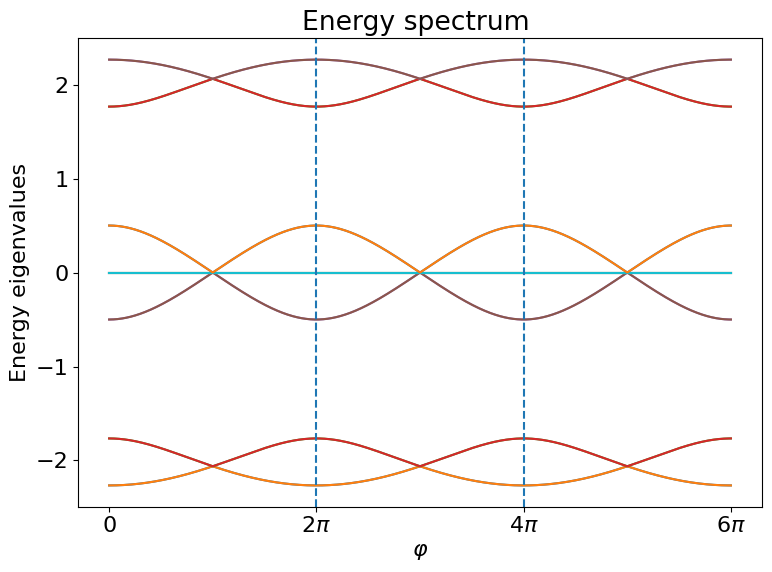

In [21]:
num_sites = 4  # total number of sites/qubits
# Define parameters
eps_param   = ParameterVector("eps", num_sites)
delta_param = ParameterVector("delta", 2)
t_param     = ParameterVector("t", 2)
tc_param    = Parameter("tc")
# Build symbolic Hamiltonian
H_param     = compute_H(eps_param, t_param, tc_param, delta_param, num_sites)

# Numerical values for on-site energies and tunneling
eps = np.zeros(num_sites)  # ε_i = 1 for all sites
tc  = 0.5                # central coupling strength

# Sweep phi from 0 to 6π
phi_list = np.linspace(0, 6*np.pi, 1000)
# Array to store the two lowest eigenvalues
n=16
levels = np.zeros((len(phi_list), n))

# Loop over phi values, bind parameters, diagonalize, and store lowest two levels
for i, phi in enumerate(phi_list):
    # pairing phases
    delta0 = np.exp(-1j * phi / 2)
    delta1 = np.exp(+1j * phi / 2)
    t0 = delta0
    t1 = delta1

    # create mapping from symbolic parameters to numeric values
    bind_map = {eps_param[j]: eps[j] for j in range(num_sites)}
    bind_map.update({t_param[0]: t0, t_param[1]: t1})
    bind_map.update({delta_param[0]: delta0, delta_param[1]: delta1})
    bind_map[tc_param] = tc

    # get numeric Hamiltonian and eigenvalues
    H_num = H_param.bind_parameters(bind_map).to_matrix()
    eigs  = np.linalg.eigvalsh(H_num)
    # save two lowest levels
    # select the 4 eigenvalues nearest to zero (smallest |E|)
    selected = np.argsort(np.abs(eigs))[:4]
    # sort these so plotting is ordered from lowest to highest
    levels[i, :] = eigs#eigs[5:11]#eigs[selected]

# Plot the selected energy levels vs varphi
plt.figure(figsize=(8,6))
for j in range(n):
    plt.plot(phi_list, levels[:, j], label=fr'$E_{{{j+1}}}(\varphi)$')

# Add vertical dashed lines at multiples of 2π
for k in range(1, 3):
    plt.axvline(2 * np.pi * k, linestyle='--')

# Label x-axis with varphi ticks at multiples of 2π
ticks = [0, 2*np.pi, 4*np.pi, 6*np.pi]
labels = [r'$0$', r'$2\pi$', r'$4\pi$', r'$6\pi$']
plt.xticks(ticks, labels)

plt.xlabel(r'$\varphi$')  # use varphi
plt.ylabel('Energy eigenvalues')
#plt.legend()
plt.title(r'Energy spectrum ')
plt.tight_layout()
plt.savefig("figures/energy/spectrum06pi_spin.pdf")
plt.show()

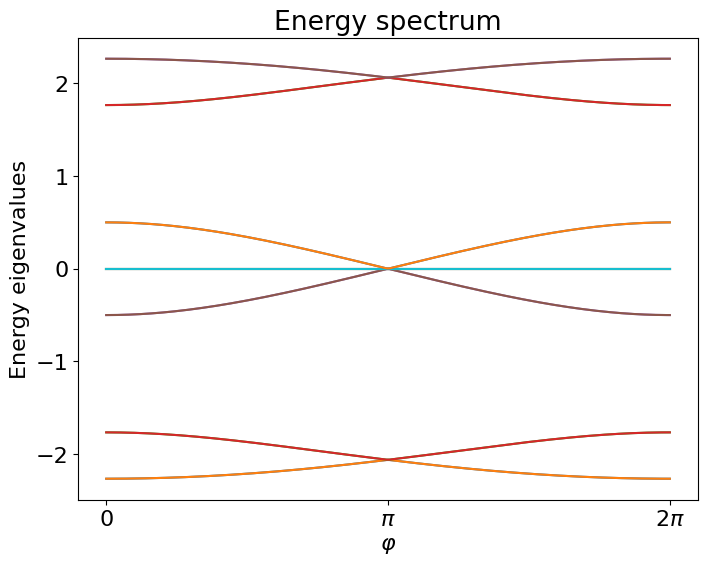

In [22]:
num_sites = 4  # total number of sites/qubits
# Define parameters
eps_param   = ParameterVector("eps", num_sites)
delta_param = ParameterVector("delta", 2)
t_param     = ParameterVector("t", 2)
tc_param    = Parameter("tc")
# Build symbolic Hamiltonian
H_param     = compute_H(eps_param, t_param, tc_param, delta_param, num_sites)

# Numerical values for on-site energies and tunneling
eps = np.zeros(num_sites)  # ε_i = 1 for all sites
tc  = 0.5                # central coupling strength

# Sweep phi from 0 to 6π
phi_list = np.linspace(0, 2*np.pi, 200)
# Array to store the two lowest eigenvalues
n = num_sites**2
levels = np.zeros((len(phi_list), n))

# Loop over phi values, bind parameters, diagonalize, and store lowest two levels
for i, phi in enumerate(phi_list):
    # pairing phases
    delta0 = np.exp(-0.5j * phi)
    delta1 = np.exp(+0.5j * phi)
    t0 = delta0
    t1 = delta1

    # create mapping from symbolic parameters to numeric values
    bind_map = {eps_param[j]: eps[j] for j in range(num_sites)}
    bind_map.update({t_param[0]: t0, t_param[1]: t1})
    bind_map.update({delta_param[0]: delta0, delta_param[1]: delta1})
    bind_map[tc_param] = tc

    # get numeric Hamiltonian and eigenvalues
    H_num = H_param.bind_parameters(bind_map).to_matrix()
    eigs  = np.linalg.eigvalsh(H_num)
    # save two lowest levels
    # select the 4 eigenvalues nearest to zero (smallest |E|)
    selected = np.argsort(np.abs(eigs))[:4]
    # sort these so plotting is ordered from lowest to highest
    levels[i, :] = eigs[:]#eigs[selected]

# Plot the selected energy levels vs varphi
plt.figure(figsize=(8,6))
for j in range(n):
    plt.plot(phi_list, levels[:, j], label=fr'$E_{{{j+1}}}(\varphi)$')

# Label x-axis with varphi ticks at multiples of 2π
ticks = [0, np.pi, 2*np.pi]
labels = [r'$0$', r'$\pi$', r'$2\pi$']
plt.xticks(ticks, labels)

plt.xlabel(r'$\varphi$')  # use varphi
plt.ylabel('Energy eigenvalues')
#plt.legend()
plt.title(r'Energy spectrum')
plt.savefig("figures/energy/spectrum02pi_sweet_spot_spin.pdf")
plt.show()

In [23]:
# p is our parameter over different initial states
p_vals = np.linspace(0, 1, 20)
energy_matrix = np.zeros((len(p_vals), 2))

# Loop over different p values for initial state preparation
for i, p_val in enumerate(tqdm(p_vals)):
    initial_state = p_val * (Zero ^ Zero ^ Zero ^ Zero) + (1 - p_val) * (One ^ One ^ One ^ One)

    # Compute the trotterized evolution operator using H
    energy = (initial_state.adjoint() @ H @ initial_state).eval()

    energy_matrix[i,0] = p_val
    energy_matrix[i,1] = energy

plt.plot(energy_matrix[:,0],energy_matrix[:,1])
plt.xlabel('p')
plt.ylabel('E')
plt.title(r'Energy for initial states $p|00\rangle + (1-p)|11\rangle$' + '\n' + r'$\varepsilon_1=\varepsilon_2=1$ and $\Delta=t=1$ ')
plt.show

  0%|          | 0/20 [00:00<?, ?it/s]


NameError: name 'H' is not defined